# Введение в глубокое обучение
## Занятие 8. Задача машинного перевода (seq2seq). Механизм Attention.


##### Credits:
* Первая часть данного занятия основана на [ноутбуке о задаче машинного перевода](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) в переводе Vasiliy Es'kin (github: [vasiliyeskin](https://github.com/vasiliyeskin)).**
* **Автор [оригинального ноутбука](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb): Ben Trevett (github: [bentrevett](https://github.com/bentrevett)).**

#### План занятия:
0. Модели последовательностей. Повторение.
2. Обработка последовательностей с помощью RNN в задаче машинного перевода
3. Механизм внимания в нейронных сетях (Attention)
4. BERT в задаче классификации текстов


### Модели последовательностей. Повторение.

На прошлых лекциях мы поняли, что текст - это последовательность токенов переменной длинны. Мы научились представлять в виде векторов отдельные токены и целые тексты. Эти представления можно подавать на вход классическим алгоритмам (например, классификации и регрессии).

Также мы рассмотрели задачу языкового моделирования - предсказания следующего токена на основании знаний о предыдущих прочитанных токенах.

Сегодня расширим свои знания и попробуем решить задачу предсказания целой последовательности на основании известной последовательности. В частности, рассмотрим пример задачи машинного перевода, где на основании последовательности слов на одном языке мы пытаемся предсказать новую последовательность - её перевод на другой язык.

### 1. Обработка последовательностей с помощью RNN в задаче машинного перевода

Суть задачи машинного перевода заключается в предсказании некоторой последовательности (перевода) на основании известной последовательности.

Любопытно, что данную задачу можно попробовать решить с помощью рекуррентной нейронной сети, которую мы обсудили на прошлом занятии. Мы можем взять одну RNN (энкодер), и с её помощью векторизовать исходную последовательность, а получившийся вектор подать другой RNN сети в качестве начального состояния, и эта сеть попробует предсказать слова на новом языке.

В данном занятии будет рассмотрена модель из статьи [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215).


![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq1.png?raw=1)

На изображении выше показан пример перевода. Предложение ввода/источника, «guten morgen», проходит через слой эмбеддинга (желтый, служит для сопоставления элементов речи (слова, предложения и т.д.) числовому вектору), а затем вводится в кодировщик (зеленый). Всегда добавляются технические токены: *начало последовательности* (`<sos>` — *start of sequence*) и *конец последовательности* (`<eos>` — *end of sequence*) в начало и конец предложения соответственно - для корректности работы реккурентной сети. На каждом временном шаге на вход в RNN кодировщика подаётся как эмбеддинг-версия текущего слова $ e (x_t)$, которая порождена слоем эмбеддинга $ e $, так и скрытое состояние из предыдущего временного шага, $ h_{t-1} $. На выход RNN кодировщика подаёт новое скрытое состояние $ h_t $.

Далее вектор этого скрытого состояния подается как начальный вектор скрытого состояния в другую рекуррентную нейронную сеть - декодер - где предсказывается следующий токен.

## Подготовка данных

Для предобработки будут использоваться библиотеки `torchtext` и `nltk`.

Загрузим параллельный корпус текстов. Это [корпус Multi30k](https://github.com/multi30k/dataset), который представляет собой набор данных из ~30 000 параллельных предложений на английском, немецком и французском языках.

In [ ]:
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchtext-0.11.0-cp39-cp39-manylinux1_x86_64.whl (8.0 MB)
  Using cached torch-1.10.0-cp39-cp39-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.


In [ ]:
from torchtext.datasets import Multi30k


train_iter = Multi30k(split="train")

# torchtext.datasets.DatasetName yield exhaustible IterableDataset.
# To fix this we convert our dataset to a list.
train_data = list(train_iter)

print(f"Number of training examples: {len(train_data)}")
print(train_data[0])

100%|██████████| 1.21M/1.21M [00:02<00:00, 418kB/s]


Number of training examples: 29000
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n', 'Two young, White males are outside near many bushes.\n')


Реализуем токенизаторы. Они используются для превращения строки, содержащей предложение, в список отдельных токенов, составляющих эту строку, например "доброе утро!" становится ["доброе", "утро", "!"].

In [ ]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize("good morning!"))

['good', 'morning', '!']


Теперь реализуем отдельную функцию для токенизации:

In [ ]:
def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())                              # привели к нижнему регистру и разбили на токены

src, trg = train_data[0]                                                          # берем первую пару "исходный язык" - "целевой язык"
                                                                                  # из обучающей выборки

print(tokenize(src))
print(tokenize(trg))

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


Построим словари (множества уникальных токенов) для исходного и целевого языков. Будем учитывать токены, которые встречаются не реже `min_freq` раз.
Словарь используется для связывания каждого уникального токена с индексом (целым числом). Словари исходного и целевого языков различаются.

In [ ]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)                                        # минимальная частота встречаемости - 2
trg_vocab = Vocab(trg_counter, min_freq=2)

Добавим технические токены. Токен `<UNK>` будет использоваться для обозначения токенов, которые не присутствовали в словаре, построенном по обучающей выборке.

In [ ]:
unk_token = "<UNK>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

Также добавим технические токены начала строки `<SOS>`, конца строки `<EOS>` и паддинга `<PAD>` (чтобы "добивать" все до максимальной длины).

In [ ]:
sos_token, eos_token, pad_token = "<SOS>", "<EOS>", "<PAD>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

Оценим полученный размер словаря

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (de) vocabulary: 7892
Unique tokens in target (en) vocabulary: 5903


Наконец, реализуем простую функцию `encode` для приведения последовательности к формату, с которым могут работать нейронные сети. Она объединяет все предыдущие наработки.

In [ ]:
def encode(sent, vocab):                                                          # функция берет любую фразу и словарь, соответствующий ей
                                                                                  # т.е. либо словарь исходного или целевого языка
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]                                      # возвращает последовательность индексов токенов вместо фразы

print(encode(src, src_vocab)[::-1])                                               # развернутая последовательность токенов
print(encode(trg, trg_vocab))

[7890, 13, 180, 6, 457, 33, 1596, 15, 46, 0, 236, 423, 157, 249, 193, 210, 3358, 33, 687, 8, 25, 18, 7889]
[5900, 18, 28, 14, 284, 89, 18, 1573, 30, 214, 256, 38, 534, 71, 18, 1051, 659, 3, 61, 1549, 89, 1421, 14, 38, 181, 11, 5901]


Последний шаг подготовки данных — создание итераторов. С их помощью можно итерационно возвращать пакеты данных, которые будут иметь атрибут `src` (тензоры PyTorch, содержащие набор оцифрованных исходных предложений) и атрибут `trg` (тензоры PyTorch, содержащие набор оцифрованных целевых предложений). Оцифрованные предложения — это просто причудливый способ сказать, что они были преобразованы из последовательности читаемых токенов в последовательность соответствующих индексов с использованием словаря.

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# функция, позволяющая нам специфицировать, как именно из датасета строить батчи, если не просто выбирать нужные нам элементы
def collate_batch(batch):
    src_list, trg_list = [], []                                                   # имеется два списка
    for src, trg in batch:                                                        # батч из обучающей выборки
        # Encode src and trg sentences, convert them into a tensor
        # and store them in src_list and trg_list respectively.
        src_encoded = encode(src, src_vocab)                                      # закодируем элементы из батча, используя src_vocab
        src_list.append(torch.tensor(src_encoded))                                # добавим в список "исходников" строку в виде токенов,
                                                                                  # отображенных в индексы
        trg_encoded = encode(trg, trg_vocab)                                      # то же самое делаем с целевой фразой
        trg_list.append(torch.tensor(trg_encoded))

    # Pad sequences with pad_sequence function.
    # src_padded = pad_sequence(...)
    # trg_padded = pad_sequence(...)
    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])       # "добьем" все токены до максимальной длины с помощью падтокена
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


batch_size = 256
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([47, 256]), torch.Size([42, 256]))

Отлично! Теперь мы можем генерировать батчи для обработки данных из обучающей выборки. Аналогичным образом обработаем валидационную выборку:

In [ ]:
val_data = list(Multi30k(split="valid"))
val_dataloader = DataLoader(val_data, batch_size, collate_fn=collate_batch)

100%|██████████| 46.3k/46.3k [00:00<00:00, 108kB/s] 


## Построение модели Seq2Seq

Модель состоит из двух частей: энкодер, декодер. Затем они будут объединены в одну модель Seq2seq.

### Энкодер

Энкодер — это двухслойная LSTM сеть. В оригинальной статье используется четырехслойная LSTM, но в целях экономии времени она была упрощена.

Энкодер — это та часть модели, которая берет входящие данные и преобразовывает их в векторный вид.

Визуально энкодер выглядит следующим образом:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq2.png?raw=1)

Ему будет соответствовать класс `Encoder`. Конструктор данного класса принимает следующие аргументы:
- `input_dim` - размер / размерность one-hot векторов, которые будут вводиться в кодировщик. Они равны размеру входного (исходного) размера словаря.
- `emb_dim` - размерность слоя эмбеддинга. Этот слой преобразует one-hot векторы в dense векторы с размерами `emb_dim`.
- `hid_dim` - размерность скрытого состояния и состояния ячейки.
- `n_layers` - количество слоев в RNN.
- `dropout` - количественная характеристика дропаута. Это параметр регуляризации для предотвращения переобучения. [Здесь]((https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR)) можно коротко вспомнить, что это такое.

Следует отметить, что аргумент `dropout` для LSTM заключается в том, сколько связей необходимо отключить между уровнями многослойной RNN, то есть между скрытыми состояниями, выводимыми из уровня $ l $, и теми же скрытыми состояниями, используемыми для ввода слоя $ l + 1 $.

RNN возвращает: `outputs` (скрытые состояния верхнего уровня для каждого временного шага), `hidden` (окончательное скрытое состояние для каждого слоя, $h_T$, наложенное друг на друга) и `cell` (конечное состояние ячейки для каждого слоя, $c_T$, наложенных друг на друга).

Размеры каждого из тензоров оставлены в виде комментариев в коде. В этой реализации `n_directions` всегда будет 1. Обратите внимание, существуют и двунаправленные RNN, и они могут иметь` n_directions` равное 2.

In [ ]:
import torch.nn as nn

# энкодер, получающий на вход батч из последовательности индексов токенов, а на выход отдает скрытое состояние
class Encoder(nn.Module):                                                         # построим конструктор класса, т.е. то, что его задает
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        # Define embedding, dropout and LSTM layers.
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        # src has a shape of [seq_len, batch_size]                                src - батч последовательности на исходном языке

        # Compute an embedding from src data and apply dropout.
        # embedded should have a shape of [seq_len, batch_size, emb_dim]
        embedded = self.embedding(src)                                            # "прогоняем" src через эмбеддинг,
                                                                                  # получаем последовательности векторов
        embedded = self.dropout(embedded)                                         # "прогоняем" src через дропаут

        # Compute the RNN output values.
        # When using LSTM, hidden should be a tuple of two tensors:
        # 1) hidden state
        # 2) cell state
        # both of shape [n_layers * n_directions, batch_size, hid_dim]
        _, hidden = self.rnn(embedded)                                            #  "прогоняем" через рекуррентную нейронную сеть

        return hidden

### Декодер

Декодер также будет представлен двуслойной LSTM. Иллюстрация декодера доступна ниже:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq3.png?raw=1)

Основное отличие декодера от энкодера в том, что он принимает начальное скрытое состояние от энкодера, что позволяет передать информацию о рассматриваемом предложении декодеру.

Аргументы и инициализация аналогичны классу `Encoder`, за исключением `output_dim`, который является размером словаря для выходной/целевой последовательности. Кроме того, добавлен слой `Linear`, используемый для прогнозирования токена на основе скрытого состояния верхнего уровня.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Define embedding, dropout and LSTM layers.
        # Additionaly, Decoder will need a linear layer to predict next token.
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)                                   # добавляется линейный классификатор

    def forward(self, input, hidden):
        # input has a shape of [batch_size]                                       input - это один элемент последовательности
        # hidden is a tuple of two tensors:
        # 1) hidden state
        # 2) cell state
        # both of shape [n_layers, batch_size, hid_dim]
        # (n_directions in the decoder shall always be 1)

        # Compute an embedding from input data and apply dropout.
        # Remember, that LSTM layer expects input to have a shape of
        # [seq_len, batch_size, emb_dim], which means that we need
        # to somehow introduce the seq_len dimension into our input tensor.
        input = input.unsqueeze(dim=0)                                             # избавимся от лишней размерности
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        # Compute the RNN output values.

        output, hidden = self.rnn(embedded, hidden)                               # "прогоняем" через rnn, делая один шаг
        # output has a shape of [seq_len, batch_size, hid dim]
        # Compute logits for the next token probabilities from RNN output.
        pred = self.out(output.squeeze(dim=0))                                    # предсказываем следующий токен с помощью классификатора

        # should have a shape [batch_size, n_tokens]
        return pred, hidden                                                       # возвращаем предсказание вероятности следующего токена
                                                                                  # и скрытое состояние на текущем шаге

### Seq2Seq

Наконец, энкодер и декодер могут быть объединены в класс `Seq2Seq`. Данный класс работает сразу с предложениями как в исходном, так и в целевом языке.
Иллюстрация всей модели доступна ниже:

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/seq2seq4.png?raw=1)

In [ ]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):                                         # приходят только два аргумента - энкодер и декодер,
                                                                                  # которые мы просто соединим
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

# проверим, что размерности скрытых состояний энкодера и декодера совпадают
        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src has a shape of [src_seq_len, batch_size]
        # trg has a shape of [trg_seq_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing, e.g. if
        # teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.n_tokens

        # tensor to store decoder predictions
        preds = []

        # Last hidden state of the encoder is used as
        # the initial hidden state of the decoder.
        hidden = self.encoder(src)                                                # получаем скрытое состояние из энкодера,
                                                                                  # просто один раз прогнав через энкодер
        # First input to the decoder is the  token.
        input = trg[0, :]

        for i in range(1, trg_len):                                               # через декодер прогоняем в цикле
            pred, hidden = self.decoder(input, hidden)                            # на каждом шаге берем последний элемент последовательности
            preds.append(pred)                                                    # предсказываем следующий элемент
            teacher_force = random.random() < teacher_forcing_ratio               # подбросим монетку для выбора: показать правильный токен
                                                                                  # из обучающей выборки,
                                                                                  # по которому модель предскажет следующий, либо работать в
                                                                                  # авторегрессионном режиме
                                                                                  # (предсказанный декодером токен подается ему же на вход)
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

### Обучение модели Seq2Seq

Процедура обучения модели имеет мало отличий от предыдущих занятий.
Также необходимо определить `torch.device`. Она используется, чтобы указать, на каком устройстве будут происходить вычисления: на GPU или на CPU. Обратимся к функции `torch.cuda.is_available()`, которая вернет `True`, если был обнаружен графический процессор.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)  # создаем энкодер
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)  # и декодер
model = Seq2Seq(enc, dec).to(device)                                              # и отправляем их на device

Оценим количество параметров в модели:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,916,175 trainable parameters


Функции потерь необходимо указать, что некоторые токены не стоит учитывать при подсчете ошибки. Для этого укажем `ignore_index` равный `<pad>`.

In [ ]:
optimizer = torch.optim.Adam(model.parameters())                                  # создаем оптимизатор и "цепляем" к модели
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

Наконец, обучим нашу модель.
Не забывайте, что для оценки на отложенной выборке, модель необходимо перевести в режим inference с помощью `model.eval()`.  Также будем использовать `with torch.no_grad()`, чтобы гарантировать, что градиенты не вычисляются на этапе валидации.

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm, trange


n_epochs = 10
clip = 1
for epoch in trange(n_epochs, desc="Epochs"):
    model.train()                                                                 # переводим модель в режим обучения
    train_loss = 0
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False):            # итерируемся по обучающему датасету
        # Use model to get prediction and compute loss using criterion.
        # After you've computed loss, zero gradients, run backprop, clip
        # gradients and update model with optimizer.
        src, trg = src.to(device), trg.to(device)                                 # получаем элементы из исходного и целевого языков,
                                                                                  # переводим на нужное устройство
        output = model(src, trg)                                                  # предсказываем с помощью модели

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)                                                    # выкидываем первый элемент из целевой последовательности

        loss = criterion(output, trg)                                             # считаем функцию потерь
        optimizer.zero_grad()                                                     # зануляем предыдущие градиенты
        loss.backward()                                                           # считаем новые градиенты
        clip_grad_norm_(model.parameters(), clip)                                 # избавляемся от больших градиентов (градиенты должны быть
                                                                                  # меньше константы clip по длине, если вектор длиннее, то
                                                                                  # сжимаем его до нужной длины)
        optimizer.step()                                                          # делаем шаг и повторяем

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch} train loss = {train_loss} ")

    model.eval()                                                                  # закончив с эпохой, переводим модель в режим evaluation,
                                                                                  # выключаем все дропауты и делаем ее менее случайной
    val_loss = 0
    with torch.no_grad():                                                         # выключаем градиенты, т.к. их не нужно считать на инференсе
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False):            # далее все то же самое, что и на обучении
            # Once again compute model prediction and loss, but don't
            # try and update model parameters with it.
            # Just use it for model evaluation.
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])                            # получаем результаты и сравниваем с истинными предсказаниями
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoch} val loss = {val_loss} ")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 0 train loss = 5.2034287829148145 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 val loss = 4.702935695648193 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 1 train loss = 4.665771337977627 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 val loss = 4.455214858055115 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 2 train loss = 4.3860307283568805 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 val loss = 4.175532341003418 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 3 train loss = 4.203130594471045 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 val loss = 4.001815140247345 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 4 train loss = 4.01711026200077 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 val loss = 3.824917256832123 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 5 train loss = 3.859925259623611 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 val loss = 3.6680334210395813 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 6 train loss = 3.7334535393798562 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 val loss = 3.589403212070465 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 7 train loss = 3.6024649686980665 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 val loss = 3.4043757915496826 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 8 train loss = 3.482486917261492 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 val loss = 3.4078444242477417 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 9 train loss = 3.3866670863670216 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 val loss = 3.2495846152305603 


Оценим качество перевода визуально. Для этого воспользуемся первыми десятью элементами из валидационной выборки:

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for src, trg in val_data[:10]:
        encoded = encode(src, src_vocab)
        encoded = torch.tensor(encoded)[:, None].to(device)
        hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

src: 'eine gruppe von männern lädt baumwolle auf einen lastwagen'
trg: 'a group of men are loading cotton onto a truck'
pred: 'a group of men are on a a .'

src: 'ein mann schläft in einem grünen raum auf einem sofa.'
trg: 'a man sleeping in a green room on a couch.'
pred: 'a man is a a a in a a .'

src: 'ein junge mit kopfhörern sitzt auf den schultern einer frau.'
trg: 'a boy wearing headphones sits on a woman's shoulders.'
pred: 'a boy boy in a is sitting on a bench .'

src: 'zwei männer bauen eine blaue eisfischerhütte auf einem zugefrorenen see auf'
trg: 'two men setting up a blue ice fishing hut on an iced over lake'
pred: 'two men are a a on a a .'

src: 'ein mann mit beginnender glatze, der eine rote rettungsweste trägt, sitzt in einem kleinen boot.'
trg: 'a balding man wearing a red life jacket is sitting in a small boat.'
pred: 'a man with a beard , a a black shirt , sitting in a of a .'

src: 'eine frau in einem rotem mantel, die eine vermutlich aus asien stammende handtasch

По результатам видно, что возникла проблема: длина последовательности оказывает значимое влияние на качество результата. Короткие последовательности переводятся достаточно хорошо, длинные - хуже (т.к. модель постепенно забывает, что было в предыдущей последовательности)

В результате, можно сформулировать следующие выводы:
* Архитектура энкодер-декодер является общим подходом к работе с данными сложной структуры.
* Рекуррентные сети способны улавливать последовательную структуру данных благодаря своей архитектуре.
* Даже сложные задачи могут быть декомпозированы на несколько простых подзадач.

### 2. Механизм внимания в нейронных сетях (Attention)



При обучении Seq2seq модели возникает проблема: для кодирования всей исходной последовательности используется небольшой вектор.

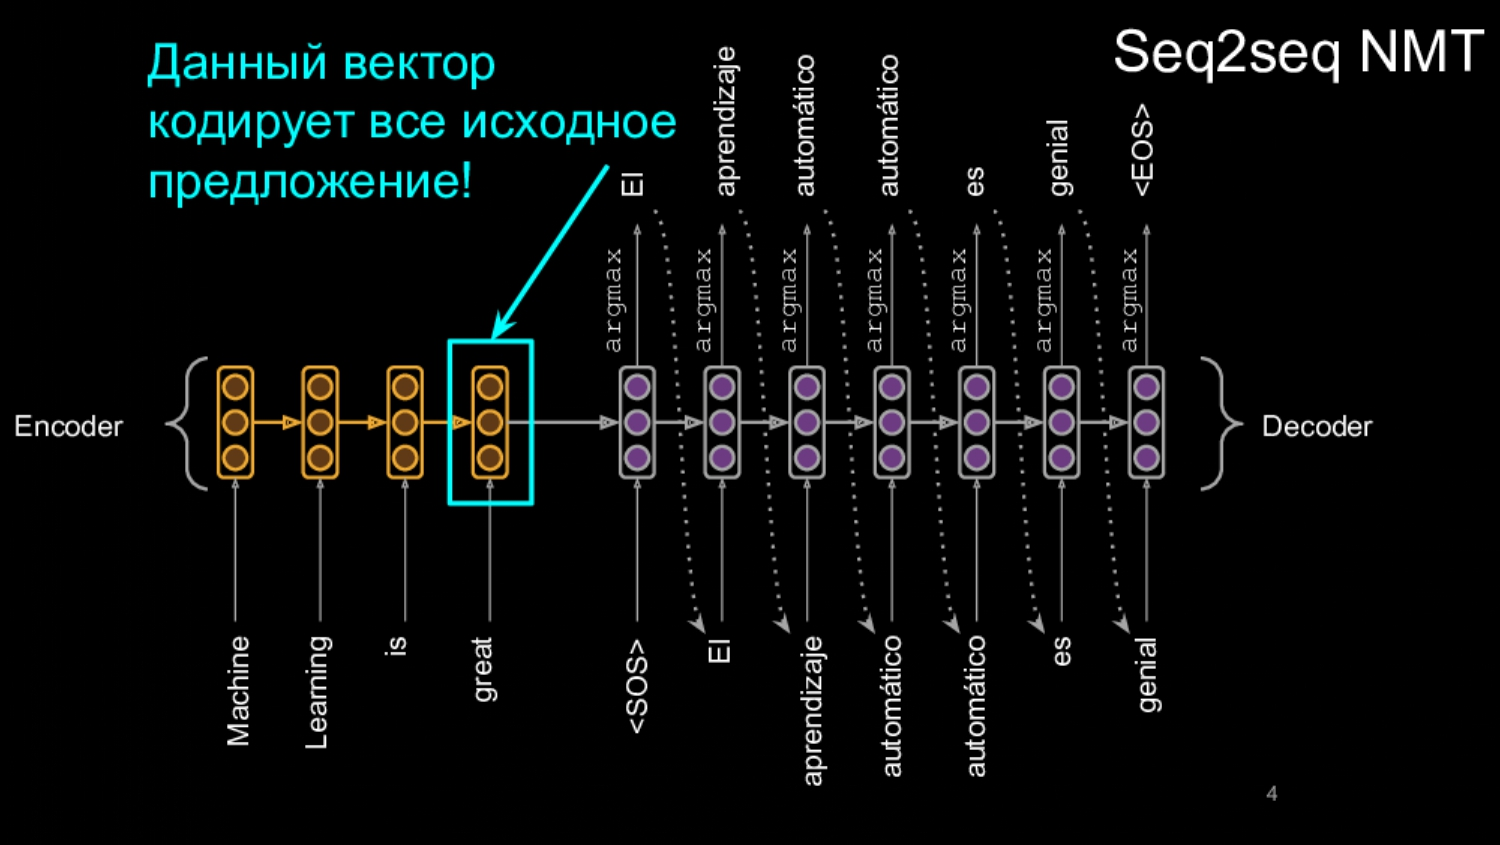

Введем некоторую операцию, которая позволит посчитать, насколько текущее состояние декодера связано со всеми состояниями энкодера. Эта операция на вход берет два вектора - состояние энкодера и состояние декодера, а на выход дает одно число. Подойдет, например, операция скалярного произведения.

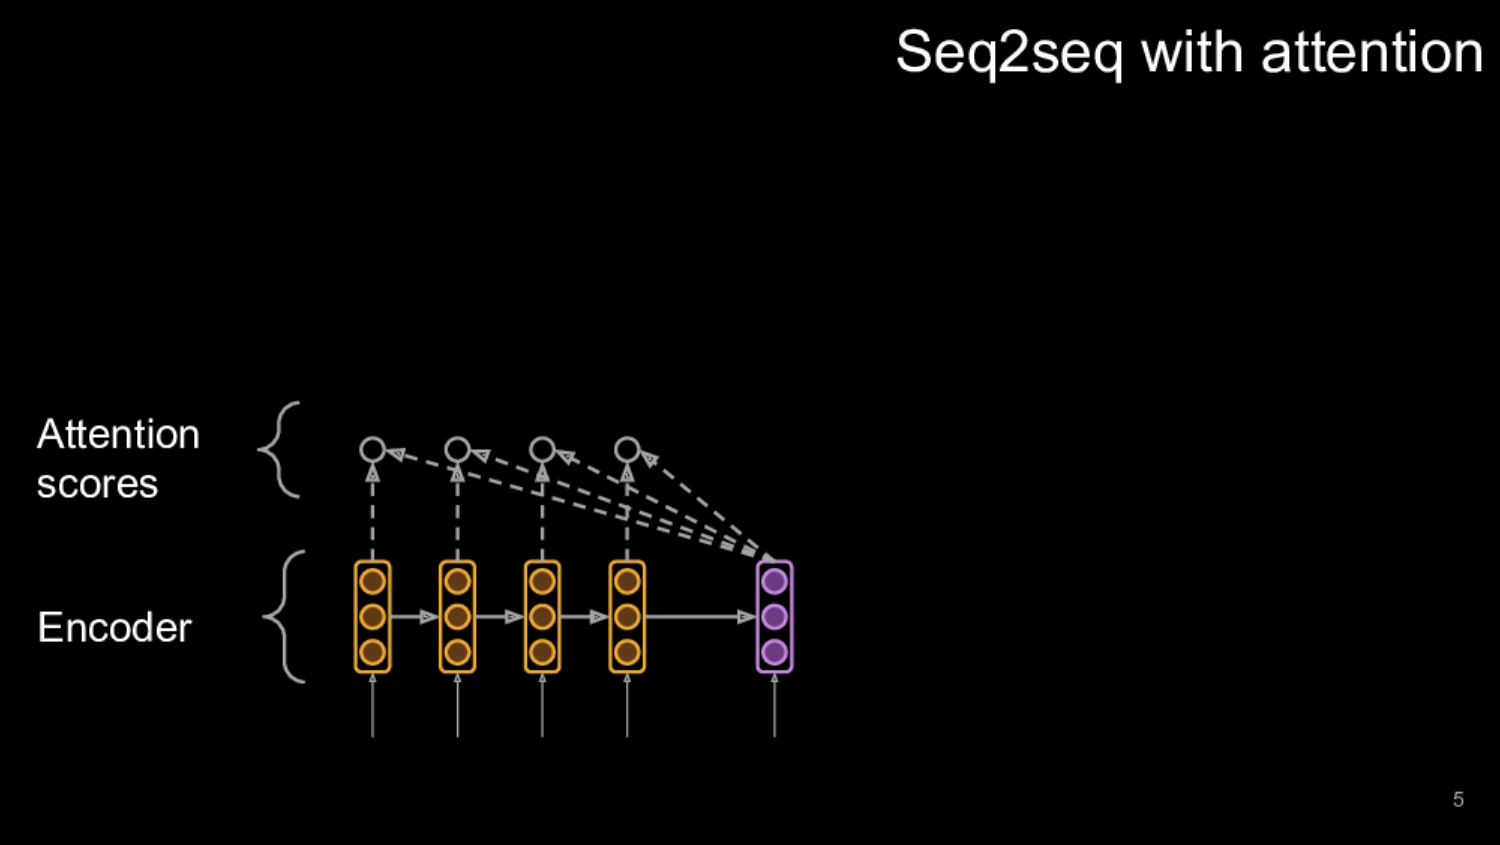

Далее ко всем числам применяем softmax и получаем attention distribution.

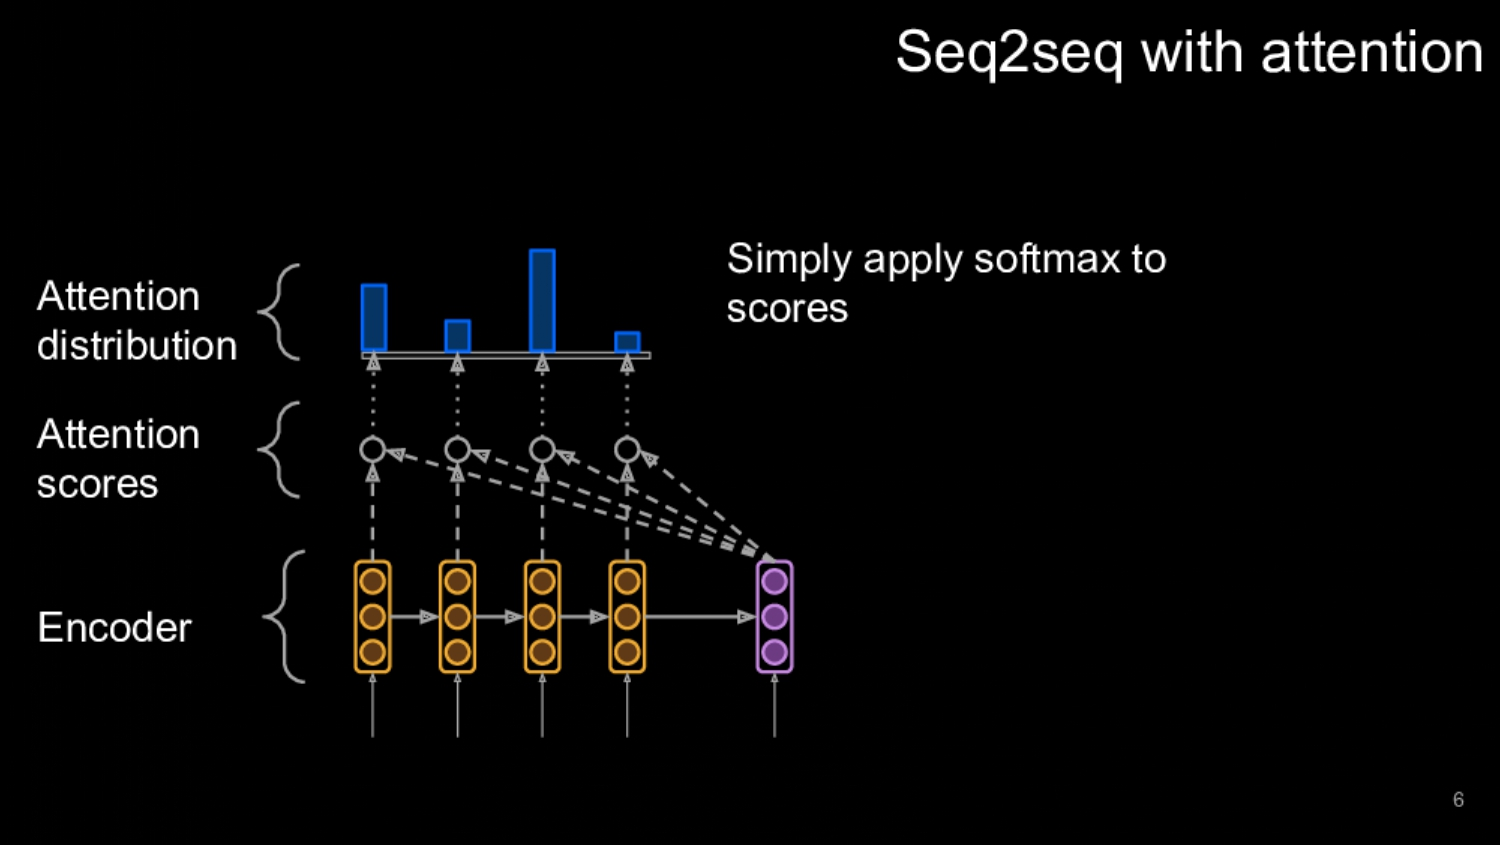

Их можно использовать как веса для каждого вектора энкодера, с которыми мы их складываем и получаем новый вектор.

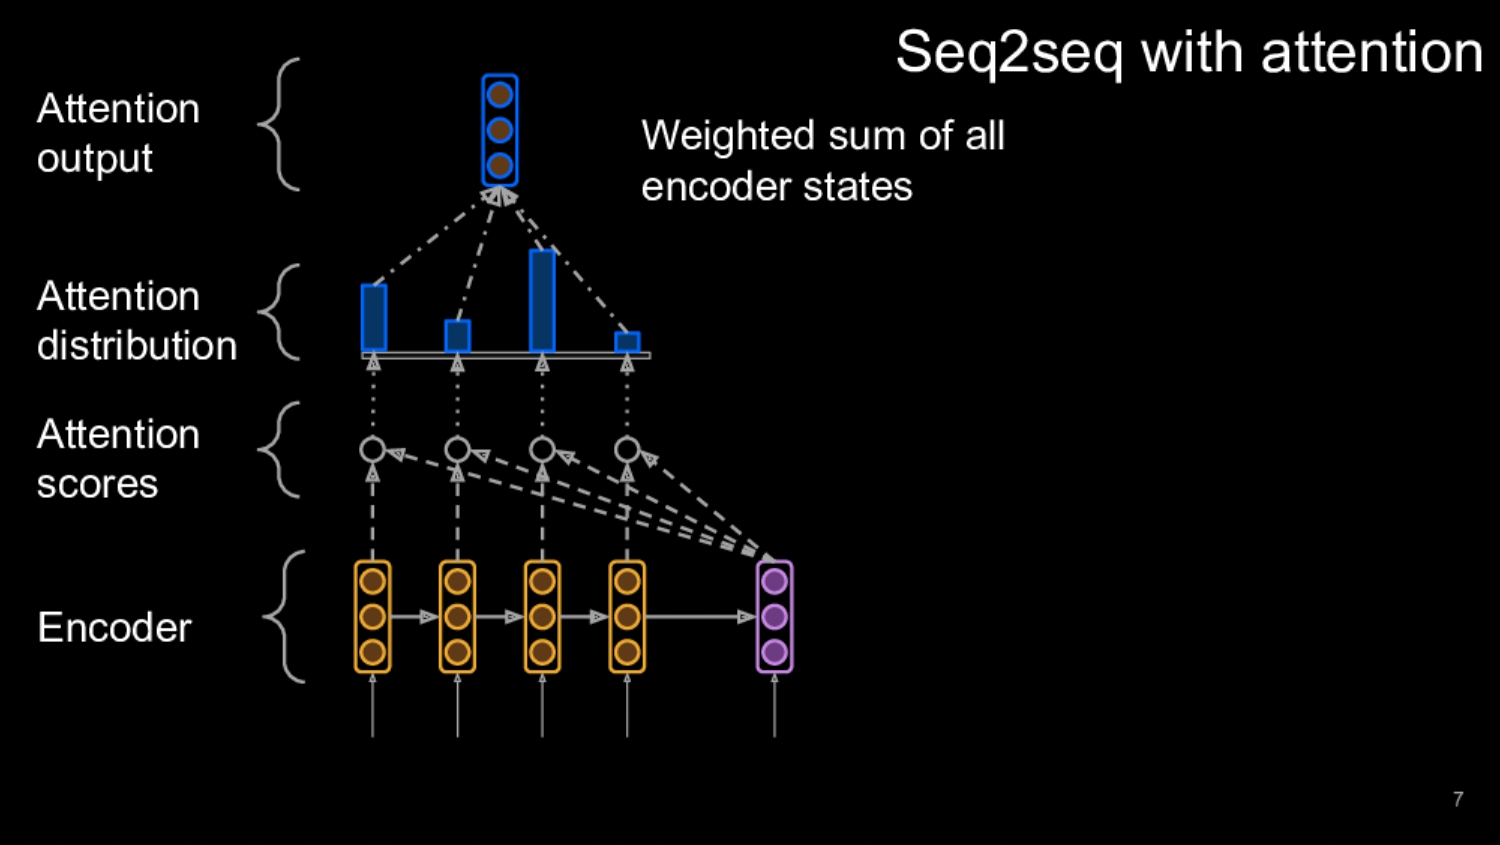

Затем берем этот вектор и отдаем декодеру.

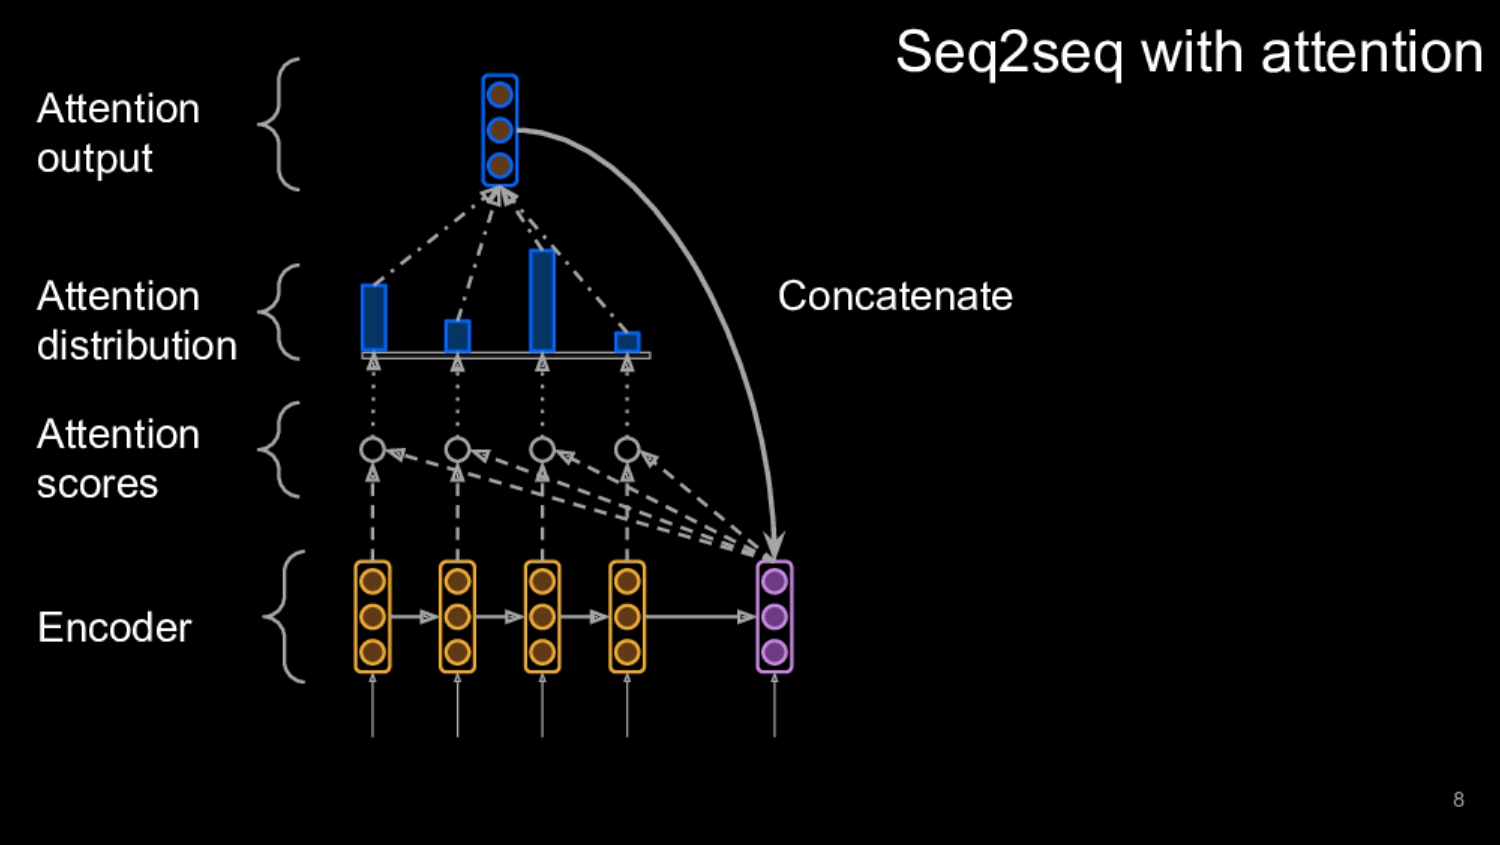

Теперь из состояния декодера и информации из энкодера, агрегированной под текущее состояние декодера, классификатор предсказывает следующий токен.

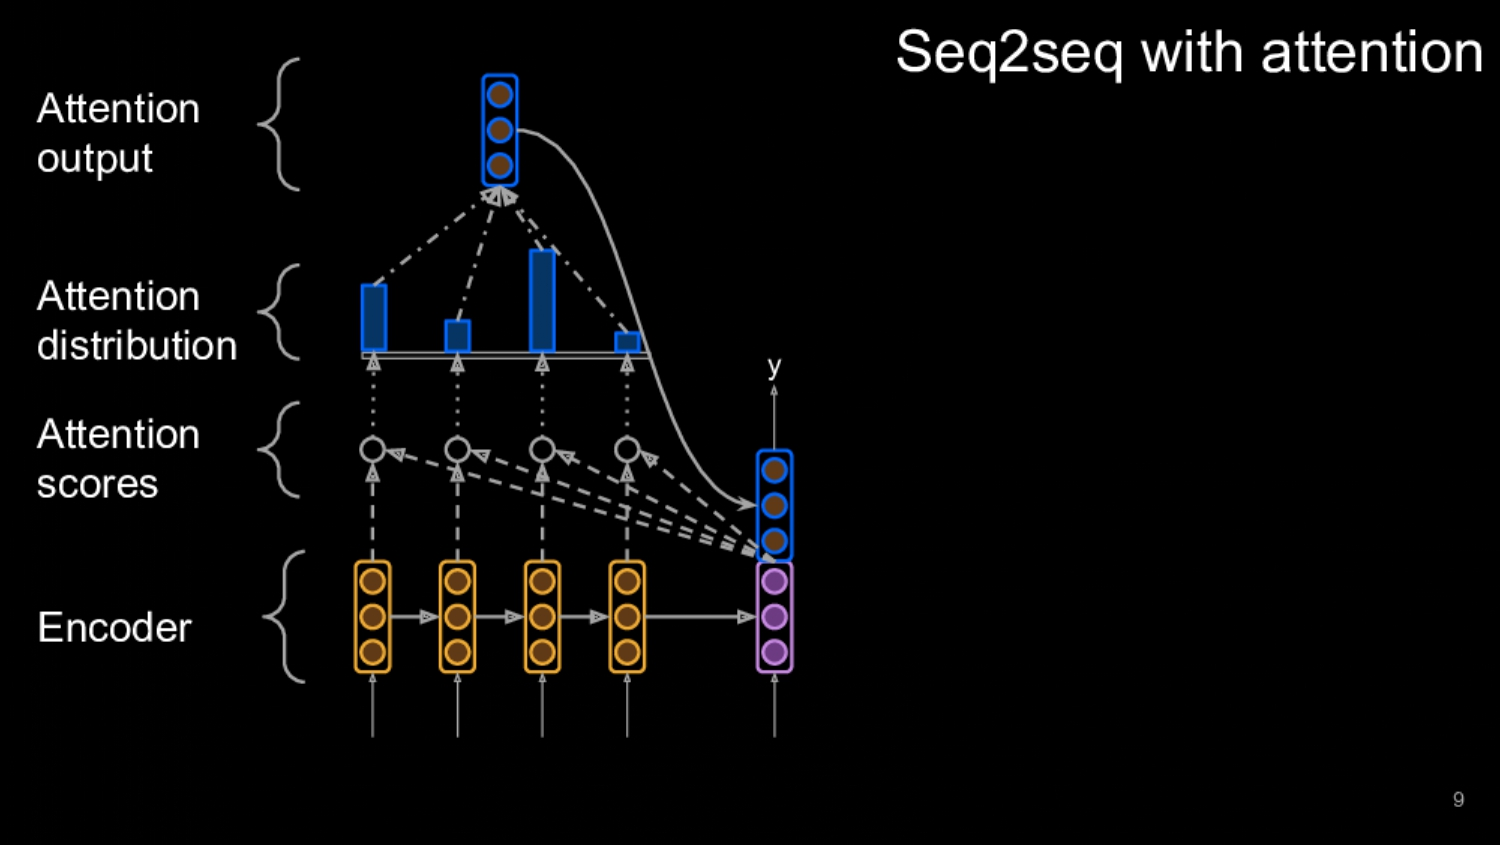

Аналогичные действия производятся на каждом шаге. Для каждого шага будут свои scores.

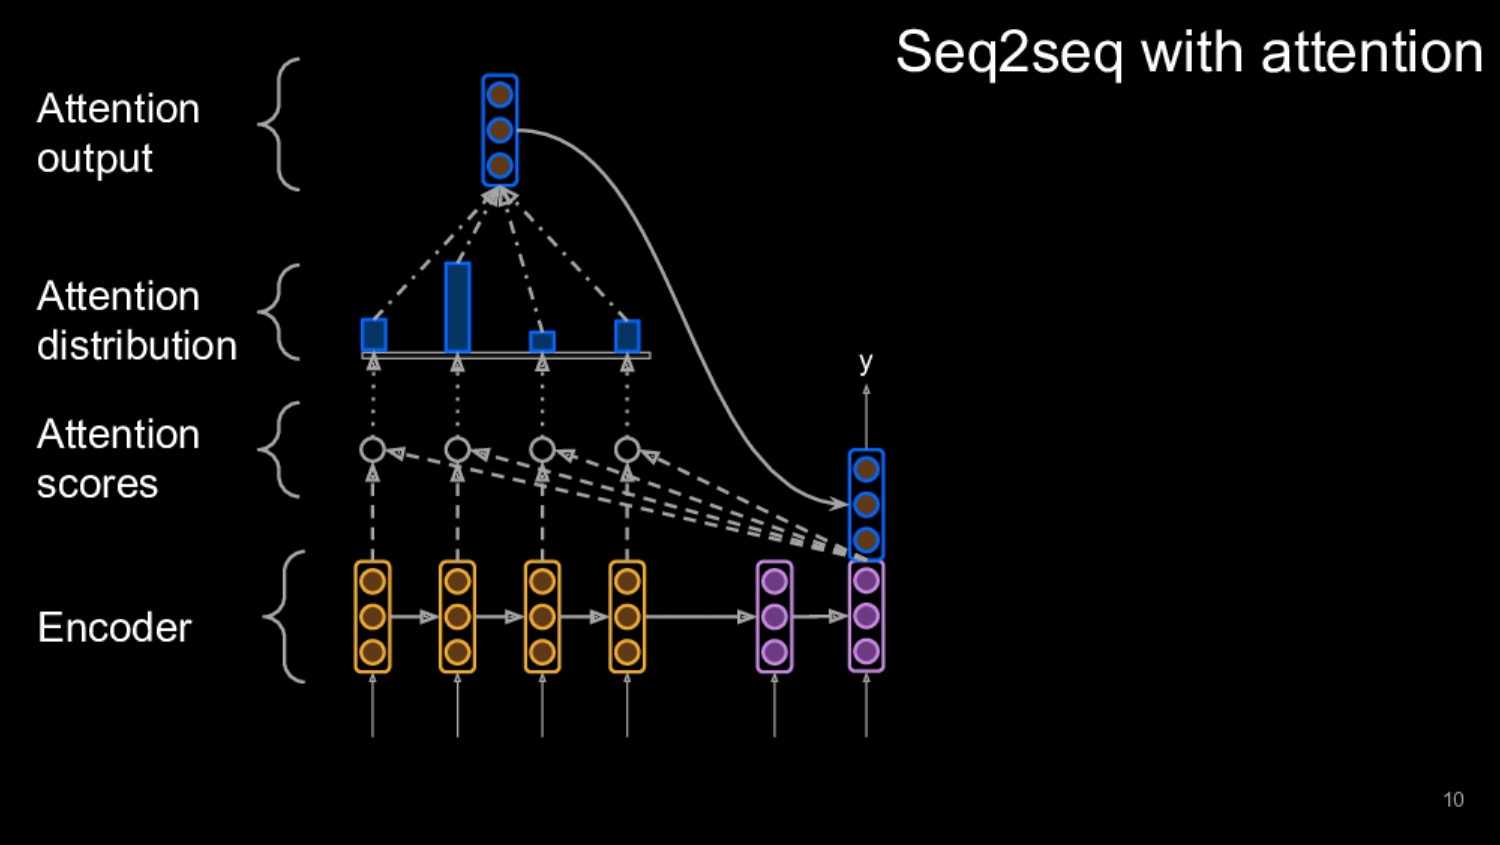

Таким образом, на каждом шаге мы умеем считать значимость всех состояний энкодера для текущего состояния декодера, согласно этой значимости их объединять, усреднять и отдавать декодеру, чтобы он мог посмотреть во все точки исходного предложения. Однако сложность алгоритма в таком случае получается квадратичная – это цена за получение гораздо более устойчивого переводчика.

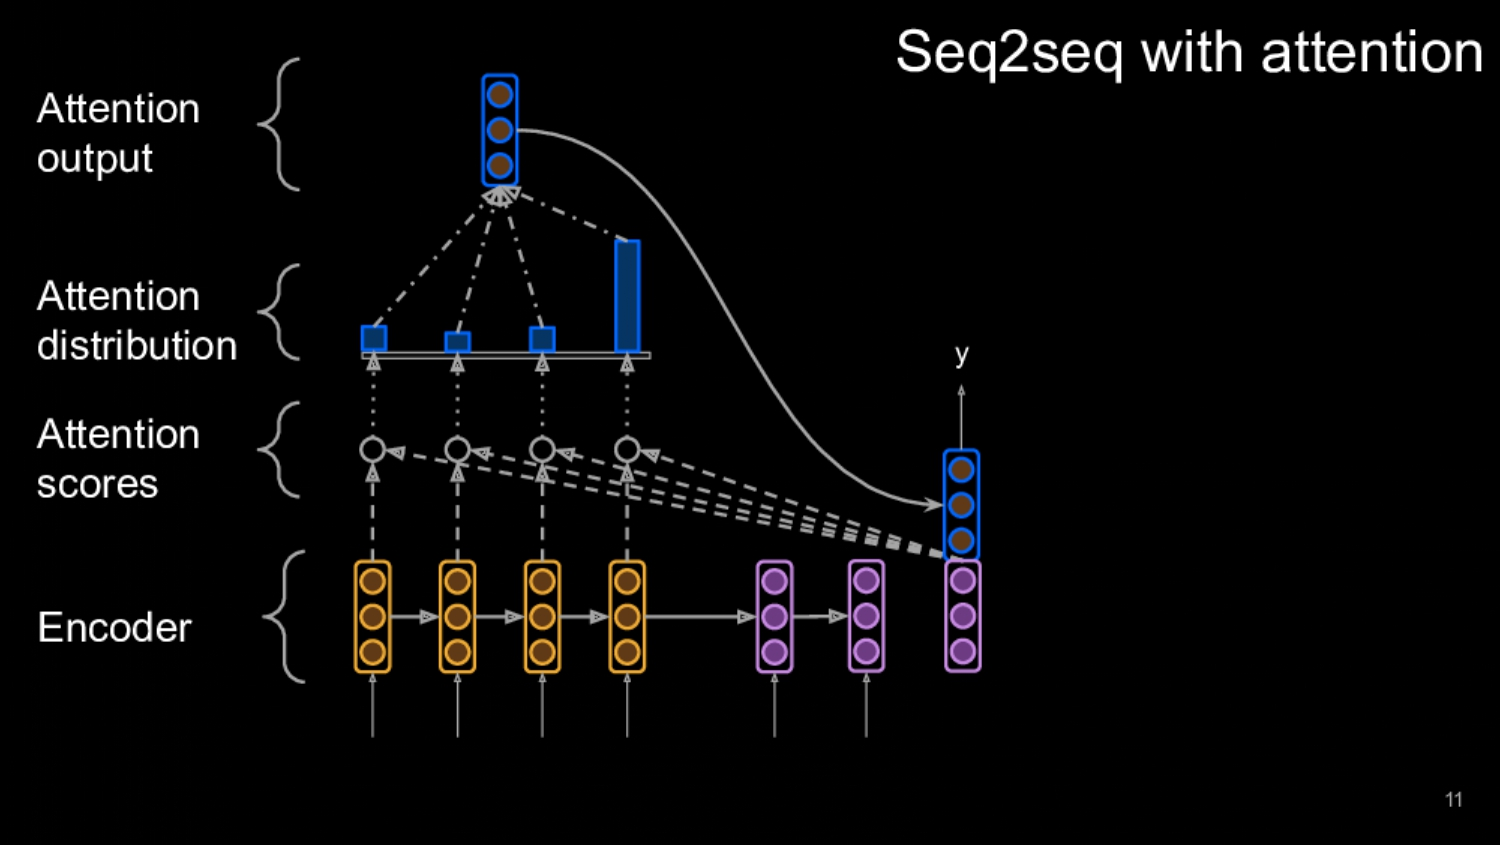

Теперь посмотрим на это в формулах.

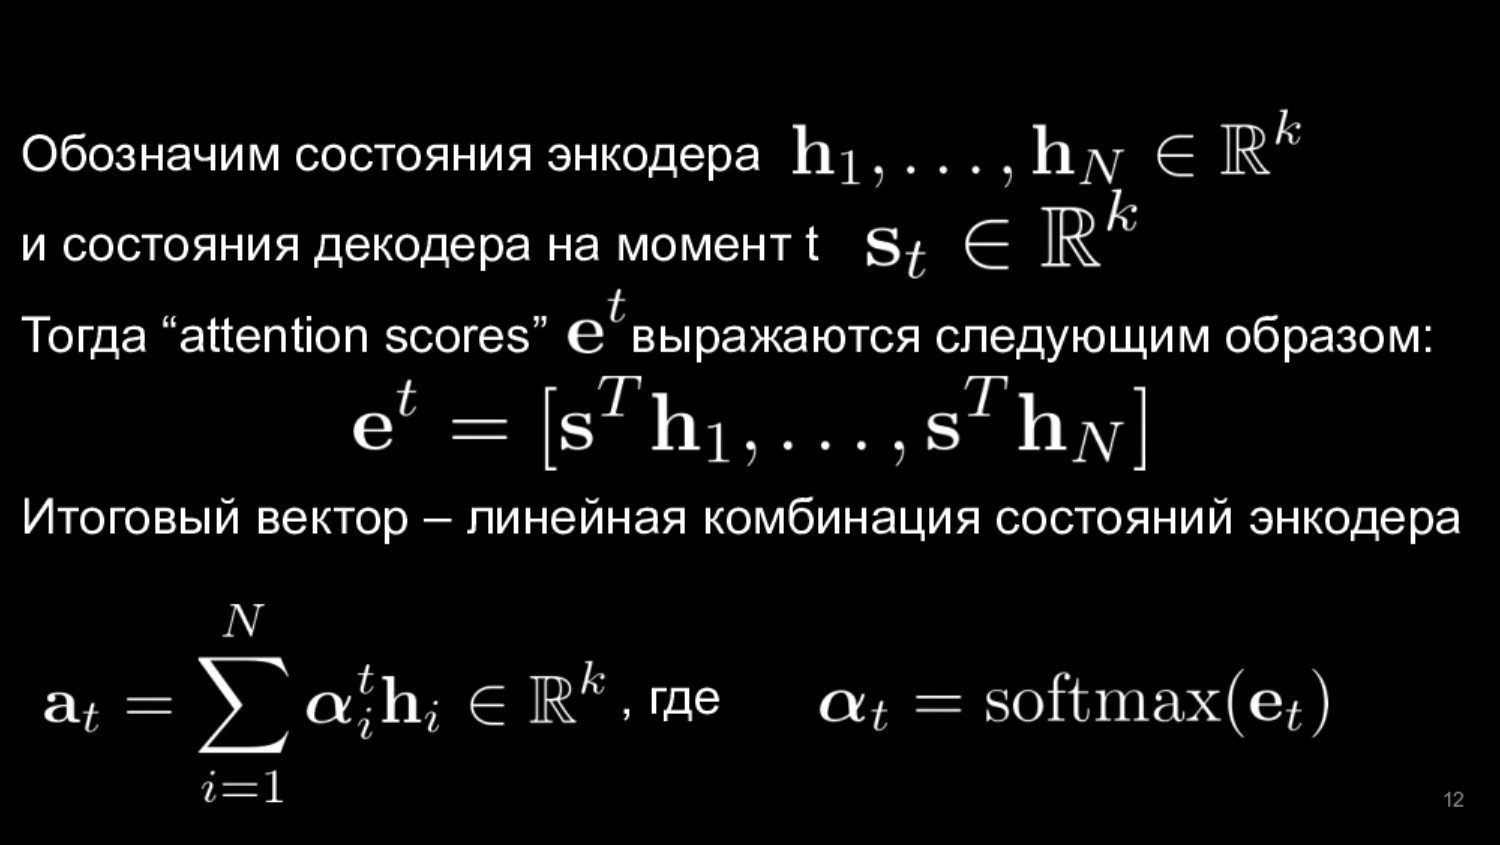

Ниже на слайде можно увидеть так называемую матрицу соответствий.

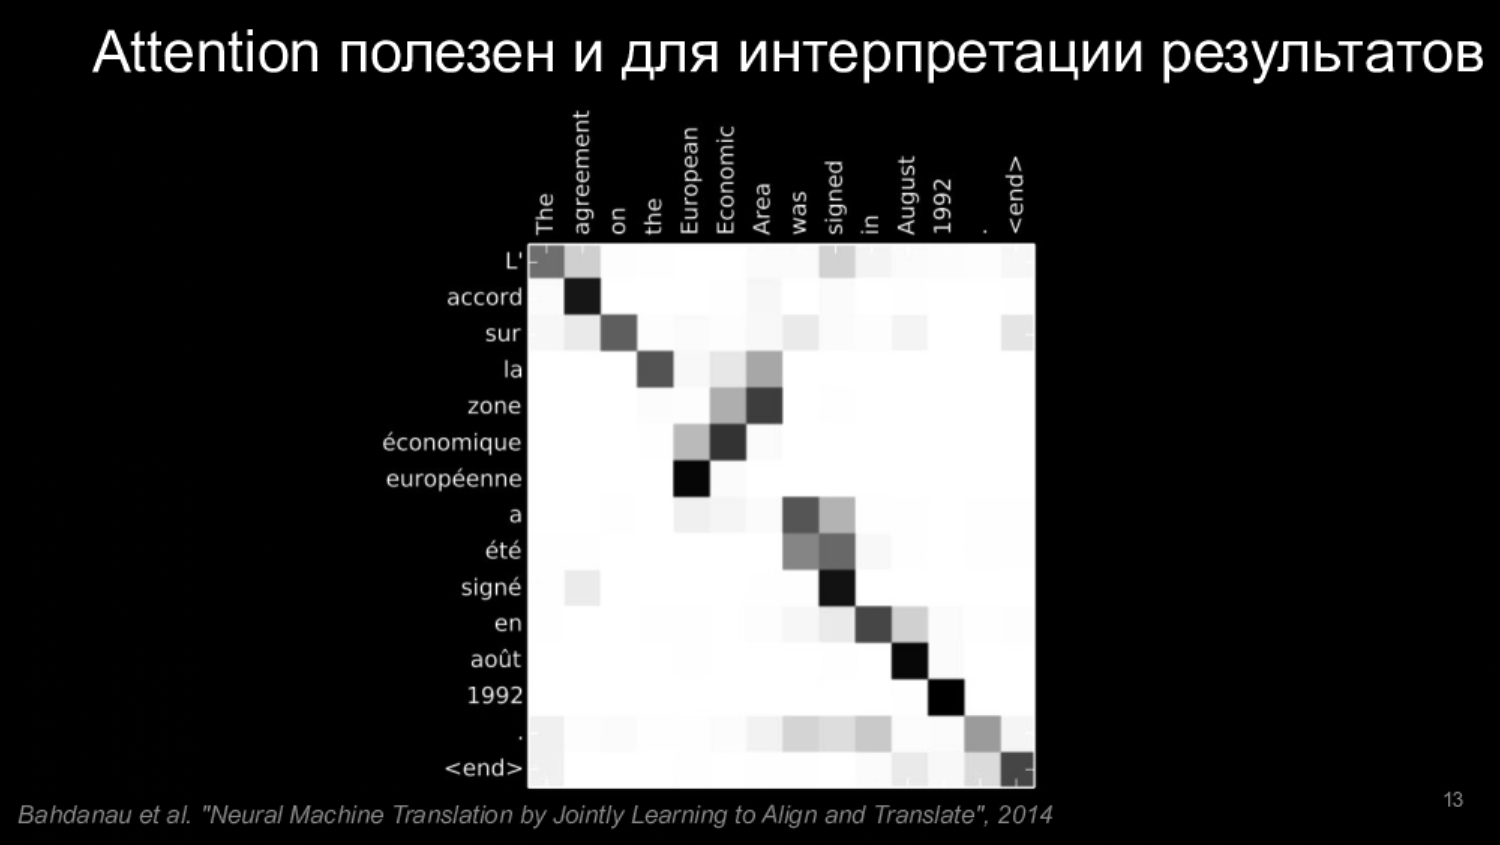

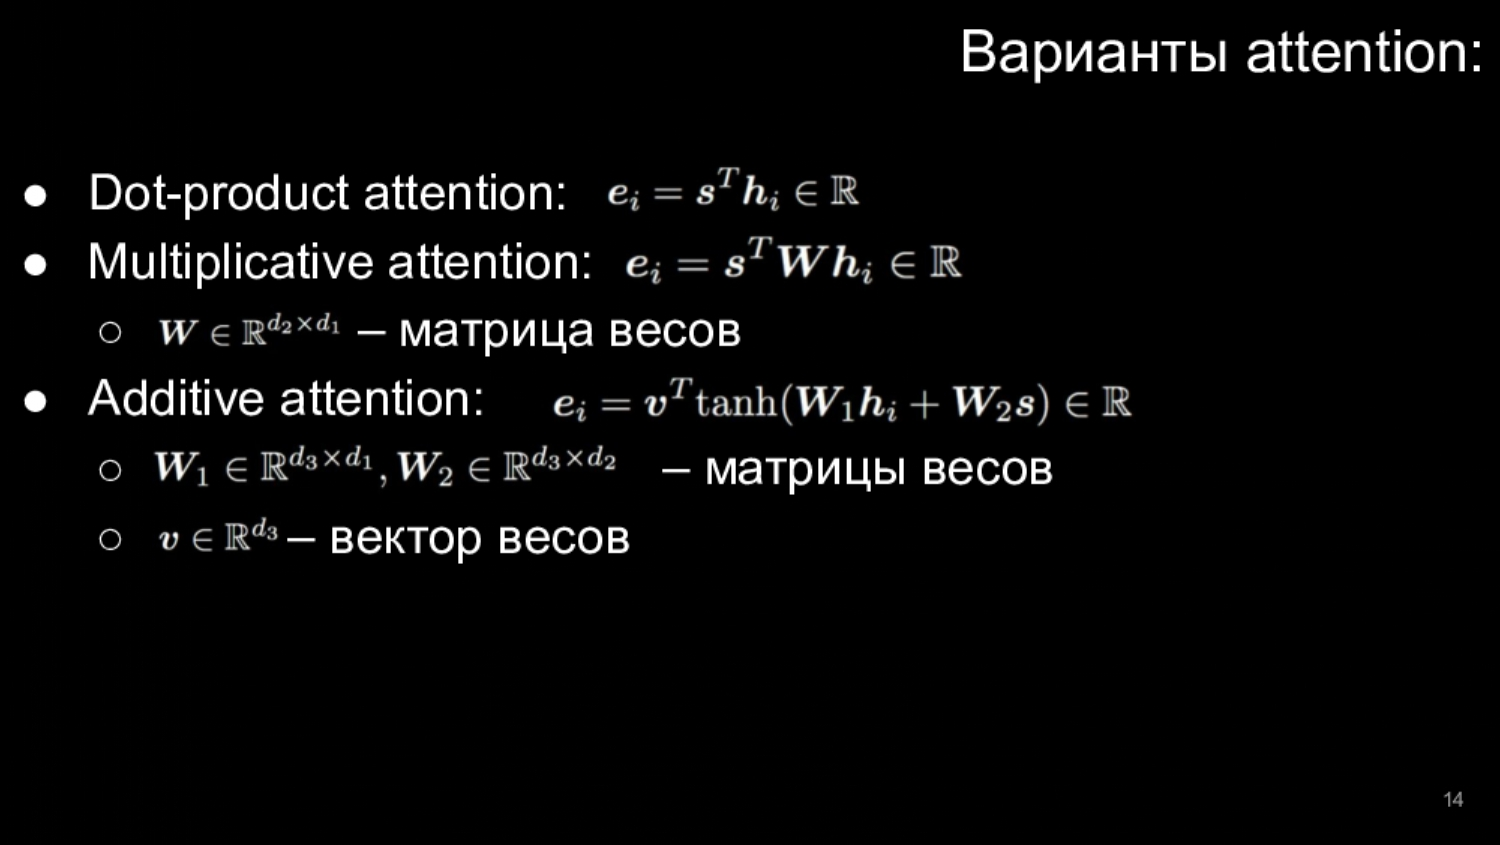

### 3. BERT в задаче классификации текстов

*Credits: last part of this notebook belongs to Jay Alammar and his [great blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) (while it has minor changes). His blog is a great way to dive into the DL and NLP concepts.*

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

Далее мы воспользуемся предобученной языковой моделью BERT и воспользуемся ей для решения уже знакомой вам задачи классификации текстов с использованием датасета SST-2.

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Процесс решения задачи можно разделить на два основных этапа:

* DistilBERT обрабатывает текст отзывов и представляет в виде вектора фиксированной размерности (768). DistilBERT – упрощенная версия модели BERT, полученная с помощью техники [дистилляции](https://www.cs.toronto.edu/~hinton/absps/distillation.pdf).

* Простая логистическая регрессия использует полученные признаковые описания для решения задачи классификации.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

Пример данных (уже знакомых вам) доступен ниже:

<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>


Также там понадобится замечетельная библиотека `transformers` которая предоставляет доступ к огромному числу предобученных моделей для работы с текстом.

In [ ]:
!pip install -Uqq transformers                                                    # установим библиотеку трансформеров

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/STT2.tsv',
    delimiter='\t',
    header=None
)

Для простоты рассмотрим только первые 2000 объектов:

In [ ]:
batch = df[:2000]

Выборку можно считать сбалансированной:

In [ ]:
batch[1].value_counts()

1    1041
0     959
Name: 1, dtype: int64

Загрузим предобученную модель:

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Для токенизации обратимся к уже существующему токенизатору. Именно он должен использоваться для токенизации текста, если планируется использование предобученной модели BERT.

In [ ]:
tokenized = batch[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

Мы можем посчитать attention между элементами одной последовательности, т.е. для каждого слова получить эмбеддинг всего предложения сквозь "призму" этого слова. Теперь мы можем какое-то слово спрятать, т.е. заменить на токен "маска". Тогда получим, что для этой позиции есть некоторый эмбеддинг всего предложения, который знает обо всем предложении, кроме этой позиции. Т.е. эмбеддинг обусловлен на все слова, кроме текущего. Это слово затем отдается классификатору. Так ставится задача маскированного языкового моделирования (задача заполнения пропусков).

С помощью padding приведем все предложения к единой длине. В общем случае стоит делать это для каждого батча отдельно, но в данном случае мы преследуюем максимальную простоту кода.

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Переменная `padded` представляет собой предобработанную версию датасета.
Ниже мы можем видеть, что `<PAD>` токенов впрямь очень много:

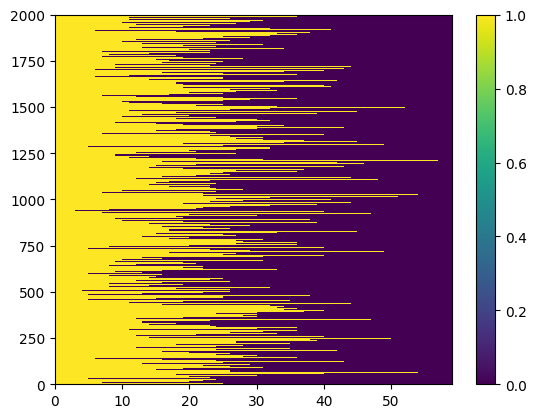

In [ ]:
plt.pcolormesh(padded>0)
plt.colorbar()

Также необходимо указать, какие из токенов не стоит учитывать при вычислении Attention. Для этого воспользуемся маской:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

Наконец, предобработаем текст с помощью BERT.
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

In [ ]:
input_ids = torch.tensor(padded)                                                  # все тексты преобразуем в тензор
attention_mask = torch.tensor(attention_mask)
model.eval()                                                                      # переводим модель в режим evaluation
with torch.no_grad():                                                             # отключаем все градиенты
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Нас интересует лишь один вектор для каждого текста. Он стоит на первой позиции и соответствует`[CLS]` (classification) токену.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()                                   # берем нулевую позицию, все элементы вектора эмбеддинга
                                                                                  # и все элементы батча
labels = batch[1]

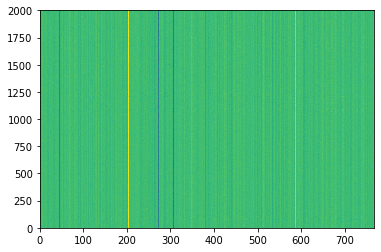

In [ ]:
# получаем матрицу признаков, которая может быть использована где угодно
plt.pcolormesh(features)

Теперь обучим классическую логистическую регрессию из `sklearn`. Перед этим разобьем выборку на `train` и `test`.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

Оценим качество классификации:

In [ ]:
lr_clf.score(train_features, train_labels)

0.916

In [ ]:
lr_clf.score(test_features, test_labels)

0.834

In [ ]:
def visualize_roc(model, X_train, X_test, y_train, y_test):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
        auc = roc_auc_score(y, proba)

        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

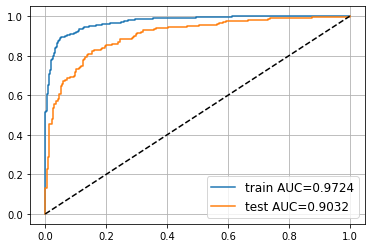

In [ ]:
visualize_roc(lr_clf, train_features, test_features, train_labels, test_labels)

Полученное качество достаточно высокое, и модель не показывает явных признаков переобучения. При этом мы использовали лишь подвыборку в 2000 объектов (до разбиения), а не весь набор данных.

#### Выводы:
* Механизм внимания (Attention) позволяет оценивать (и выделять) значимость различных элементов последовательностей друг для друга.
* Механизм внимания может быть использован как в задачах обработки текстов, так и при работе с другими данными, обладающими сложной структурой (изображения, видео, графы и др.)
* В настоящий момент архитектуры, основанные на чуть измененном механизме внимания (Self-attention) показывают state of the art результаты во множестве задач.
* Предобученные модели позволяют использовать "знания", полученные в других задачах. Их использование значительно упрощает решение прикладных задач.
* Многие подходы на самом деле похожи друг на друга и исходят из похожих (и достаточно простых) предположений.